:::python
python drive.py model.json


In [1]:
import os
import csv
from sklearn.model_selection import train_test_split
import cv2
import numpy as np
import sklearn
import math
import matplotlib.pyplot as plt
%matplotlib inline 
import pandas as pd
import itertools


In [2]:
## read udacity dataset

df = pd.read_csv('../dataFinal/data_udacity/driving_log.csv', header=0)

df.columns = ['center_image', 'left_image', 'right_image', 'steering_angle', 'throttle', 'break', 'speed']

df['center_image'] = df['center_image'] = '../dataFinal/data_udacity/IMG/' + df['center_image'].map(lambda x: x.rsplit('/')[-1])
df['left_image'] = df['left_image'] = '../dataFinal/data_udacity/IMG/' + df['left_image'].map(lambda x: x.rsplit('/')[-1])
df['right_image'] = df['right_image'] = '../dataFinal/data_udacity/IMG/' + df['right_image'].map(lambda x: x.rsplit('/')[-1])

print('length of udacity dataset: %d' %len(df))
df[0:3]



length of udacity dataset: 8036


center_image  \
0  ../dataFinal/data_udacity/IMG/center_2016_12_0...   
1  ../dataFinal/data_udacity/IMG/center_2016_12_0...   
2  ../dataFinal/data_udacity/IMG/center_2016_12_0...   

                                          left_image  \
0  ../dataFinal/data_udacity/IMG/left_2016_12_01_...   
1  ../dataFinal/data_udacity/IMG/left_2016_12_01_...   
2  ../dataFinal/data_udacity/IMG/left_2016_12_01_...   

                                         right_image  steering_angle  \
0  ../dataFinal/data_udacity/IMG/right_2016_12_01...             0.0   
1  ../dataFinal/data_udacity/IMG/right_2016_12_01...             0.0   
2  ../dataFinal/data_udacity/IMG/right_2016_12_01...             0.0   

   throttle  break      speed  
0       0.0    0.0  22.148290  
1       0.0    0.0  21.879630  
2       0.0    0.0   1.453011

In [3]:
# read recovery dataset made available by patrick kern
df_recovery = pd.read_csv('../dataFinal/track1_recovery/driving_log.csv', header=0)
df_recovery.columns = ['center_image', 'left_image', 'right_image', 'steering_angle', 'throttle', 'break', 'speed']
df_recovery['center_image'] = df_recovery['center_image'] = '../dataFinal/track1_recovery/IMG/' + df_recovery['center_image'].map(lambda x: x.rsplit('/')[-1])        
df_recovery['left_image'] = df_recovery['left_image'] = '../dataFinal/track1_recovery/IMG/' + df_recovery['left_image'].map(lambda x: x.rsplit('/')[-1])        
df_recovery['right_image'] = df_recovery['center_image'] = '../dataFinal/track1_recovery/IMG/' + df_recovery['center_image'].map(lambda x: x.rsplit('/')[-1])        
# df_recovery['left_image'] = df_recovery['left_image'] = '../dataFinal/data_udacity/' + df['left_image'].astype(str)
# df_recovery['right_image'] = df_recovery['right_image'] = '../dataFinal/data_udacity/' + df['right_image'].astype(str)
print('length of udacity dataset: %d' %len(df_recovery))
df_recovery[0:3]


length of udacity dataset: 789


center_image  \
0  ../dataFinal/track1_recovery/IMG/center_2016_1...   
1  ../dataFinal/track1_recovery/IMG/center_2016_1...   
2  ../dataFinal/track1_recovery/IMG/center_2016_1...   

                                          left_image  \
0  ../dataFinal/track1_recovery/IMG/left_2016_11_...   
1  ../dataFinal/track1_recovery/IMG/left_2016_11_...   
2  ../dataFinal/track1_recovery/IMG/left_2016_11_...   

                                         right_image  steering_angle  \
0  ../dataFinal/track1_recovery/IMG/center_2016_1...             0.0   
1  ../dataFinal/track1_recovery/IMG/center_2016_1...             0.0   
2  ../dataFinal/track1_recovery/IMG/center_2016_1...             0.0   

   throttle  break     speed  
0  0.713815      0  30.11662  
1  0.713815      0  30.11629  
2  0.713815      0  30.11551

../dataFinal/data_udacity/IMG/left_2016_12_01_13_31_13_991.jpg


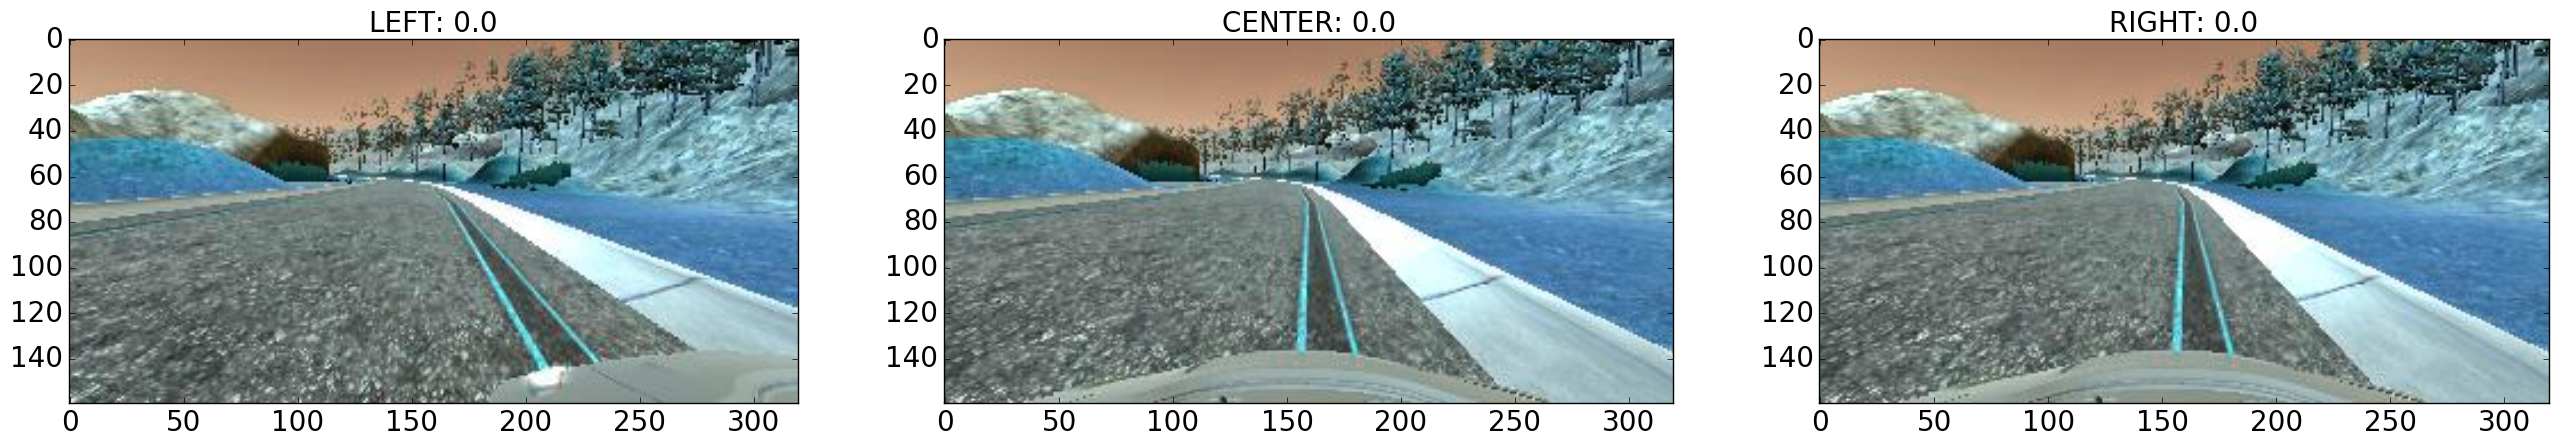

In [9]:
# Visualize sample image

chk_idx = 12
print  df['left_image'][chk_idx].strip()

img_left = cv2.imread(df_recovery['left_image'][chk_idx].strip())
img_center = cv2.imread(df_recovery['center_image'][chk_idx].strip())
img_right = cv2.imread(df_recovery['right_image'][chk_idx].strip())
angle = df['steering_angle'][chk_idx]

# Keeping the 640 x 480 perspective 
plt.rcParams['figure.figsize'] = [32, 24]
plt.tick_params(axis='x', labelsize=25)

plt.subplot(1, 3, 1)
plt.imshow(img_left)
plt.title("LEFT: " + str(np.round(angle, 2)), fontsize=20)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)

plt.subplot(1, 3, 2)
plt.imshow(img_center)
plt.title("CENTER: " + str(np.round(angle, 2)), fontsize=20)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)

plt.subplot(1, 3, 3)
plt.imshow(img_right)
plt.title("RIGHT: " + str(np.round(angle, 2)), fontsize=20)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)

#plt.tight_layout()
plt.show()

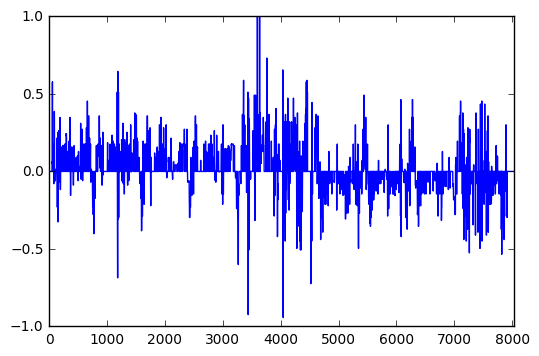

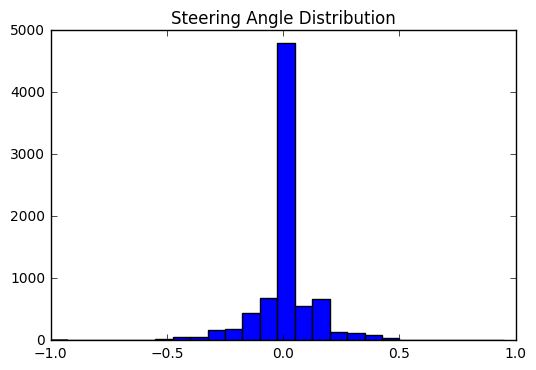

In [10]:
# Distribution analysis of steering angles 

# Time Series plot of steering angles
plt.figure(figsize=(6, 4))
ts = df["steering_angle"]
ts.plot()

plt.figure(figsize=(6,4))
plt.hist(ts.astype('float'), bins=np.arange(-1.0, 1.0, 0.075))
plt.title("Steering Angle Distribution")
plt.show()

In [11]:
# Take a look at https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

def sampleData(df):
    df_right = []
    df_left = []
    df_center = []
    for i in range(len(df)):
        center_img = df["center_image"][i]
        left_img = df["left_image"][i]
        right_img = df["right_image"][i]
        angle = df["steering_angle"][i]
#         print (angle)

        if (angle > 0.15):
            df_right.append([center_img, left_img, right_img, angle])

            # I'm adding a small deviation of the angle 
            # This is to create more right turning samples for the same image
            for i in range(10):
                new_angle = angle * (1.0 + np.random.uniform(-1, 1)/30.0)
                df_right.append([center_img, left_img, right_img, new_angle])

        elif (angle < -0.15):
            df_left.append([center_img, left_img, right_img, angle])

            # I'm adding a small deviation of the angle
            # This is to create more left turning samples for the same image
            for i in range(15):
                new_angle = angle * (1.0 + np.random.uniform(-1, 1)/30.0)
                df_left.append([center_img, left_img, right_img, new_angle])

        else:
            if (angle != 0.0):
                # Include all near 0 angle data
                df_center.append([center_img, left_img, right_img, angle])
    return df_left, df_center, df_right

df_left_u, df_center_u, df_right_u = sampleData(df)
df_left_r, df_center_r, df_right_r = sampleData(df_recovery)

df_left = df_left_u + df_left_r #itertools.chain(df_left_u, df_left_r)
df_center = df_center_u + df_center_r
df_right = df_right_u + df_right_r


print('data after udacity: left %d, center %d, right %d' %(len(df_left_u), len(df_center_u), len(df_right_u) ))
print('data after recovery: left %d, center %d, right %d' %(len(df_left_r), len(df_center_r), len(df_right_r) ))
print('data after concatenation: left %d, center %d, right %d' %(len(df_left), len(df_center), len(df_right) ))




data after udacity: left 9488, center 2180, right 9922
data after recovery: left 2304, center 223, right 880
data after concatenation: left 11792, center 2403, right 10802


In [12]:
# shuffle and name the columns in dataframe

np.random.shuffle(df_center)
np.random.shuffle(df_left)
np.random.shuffle(df_right)

df_center = pd.DataFrame(df_center, columns=["center_image", "left_image", "right_image", "steering_angle"])
df_left = pd.DataFrame(df_left, columns=["center_image", "left_image", "right_image", "steering_angle"])
df_right = pd.DataFrame(df_right, columns=["center_image", "left_image", "right_image", "steering_angle"])

# df_center[0:2]
# df_left[0:2]

## concate data and split into training testing 

data_list = [df_left, df_center, df_right]
data_df = pd.concat(data_list, ignore_index=True)

print('length of dataset: %d' %len(data_df) )

length of dataset: 24997


In [14]:

# y_data is not used as it is already contained in X_data's column
# but I made it to conform to the train_test_split function format

X_data = data_df[['center_image', 'left_image', 'right_image', 'steering_angle']]
y_data = data_df['steering_angle']

# train test split
X_train, X_valid, y_train, y_valid = train_test_split(X_data, y_data, test_size=0.2)

# reset index
X_train = X_train.reset_index(drop=True)
X_valid = X_valid.reset_index(drop=True)


X_train[0:5]

print('print length of final dataset training: %d, validation: %d ' %(len(X_train), len(X_valid) ) )

print length of final dataset training: 19997, validation: 5000 


In [15]:
## processing data 

def change_brightness(image):
    # Randomly select a percent change
    change_pct = np.random.uniform(0.4, 1.2)
    # Change to HSV to change the brightness V
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    hsv[:,:,2] = hsv[:,:,2] * change_pct
    #Convert back to RGB 
    img_brightness = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    return img_brightness

####################################################################
def flip_image(image, angle):
    img_flip = cv2.flip(image,1)
    angle = -angle
    return img_flip, angle

../dataFinal/data_udacity/IMG/left_2016_12_01_13_36_46_605.jpg


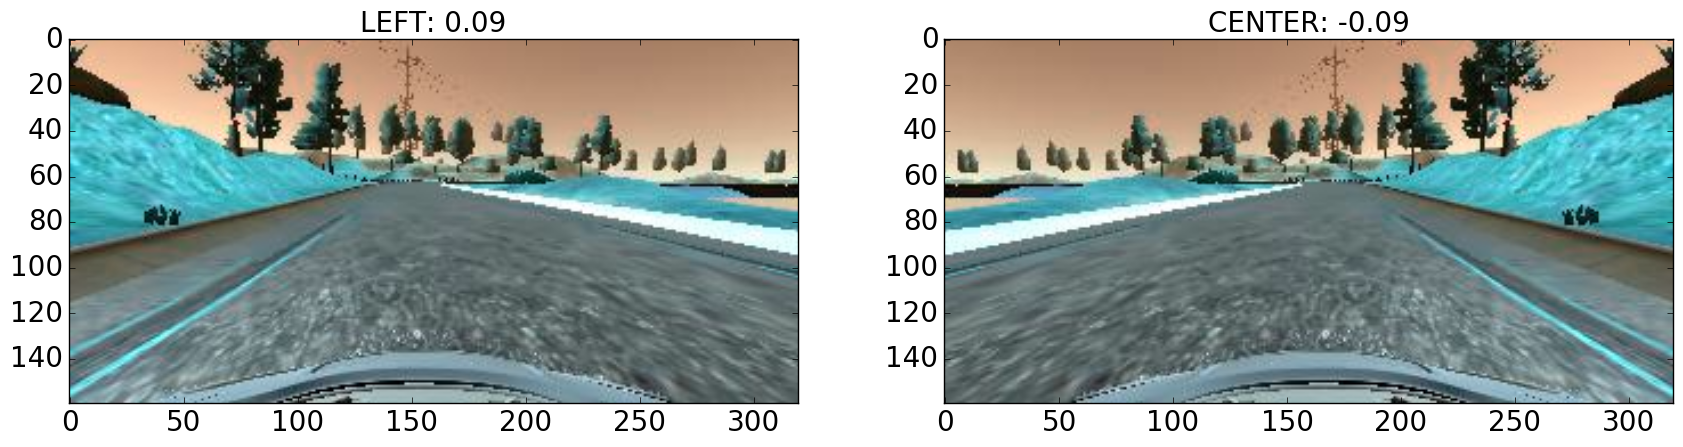

In [19]:
# Visualize fliping image

chk_idx = 8
print  df['left_image'][chk_idx].strip()

img_left = cv2.imread(df['left_image'][chk_idx].strip())
img_center = cv2.imread(df['center_image'][chk_idx].strip())
img_right = cv2.imread(df['right_image'][chk_idx].strip())
angle = df['steering_angle'][chk_idx]

# Keeping the 640 x 480 perspective 
plt.rcParams['figure.figsize'] = [32, 24]
plt.tick_params(axis='x', labelsize=25)

plt.subplot(2, 3, 1)
plt.imshow(img_center)
plt.title("CENTER: " + str(np.round(angle, 2)), fontsize=20)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)

img_center, angle = flip_image(img_center, angle)

plt.subplot(2, 3, 2)
plt.imshow(img_center)
plt.title("CENTER: " + str(np.round(angle, 2)), fontsize=20)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)


# plt.subplot(2, 3, 3)
# plt.imshow(img_right)
# plt.title("RIGHT: " + str(np.round(angle, 2)), fontsize=20)
# plt.tick_params(axis='x', labelsize=20)
# plt.tick_params(axis='y', labelsize=20)

# img_left, angle = flip_image(img_left, angle)
# img_center, angle = flip_image(img_center, angle)
# img_right, angle = flip_image(img_right, angle)

# plt.subplot(3, 3, 4)
# plt.imshow(img_left)
# plt.title("LEFT: " + str(np.round(angle, 2)), fontsize=20)
# plt.tick_params(axis='x', labelsize=20)
# plt.tick_params(axis='y', labelsize=20)

# plt.subplot(3, 3, 5)
# plt.imshow(img_center)
# plt.title("CENTER: " + str(np.round(angle, 2)), fontsize=20)
# plt.tick_params(axis='x', labelsize=20)
# plt.tick_params(axis='y', labelsize=20)

# plt.subplot(3, 3, 6)
# plt.imshow(img_right)
# plt.title("RIGHT: " + str(np.round(angle, 2)), fontsize=20)
# plt.tick_params(axis='x', labelsize=20)
# plt.tick_params(axis='y', labelsize=20)


#plt.tight_layout()
plt.show()

('angle:', -0.20087660000000002)


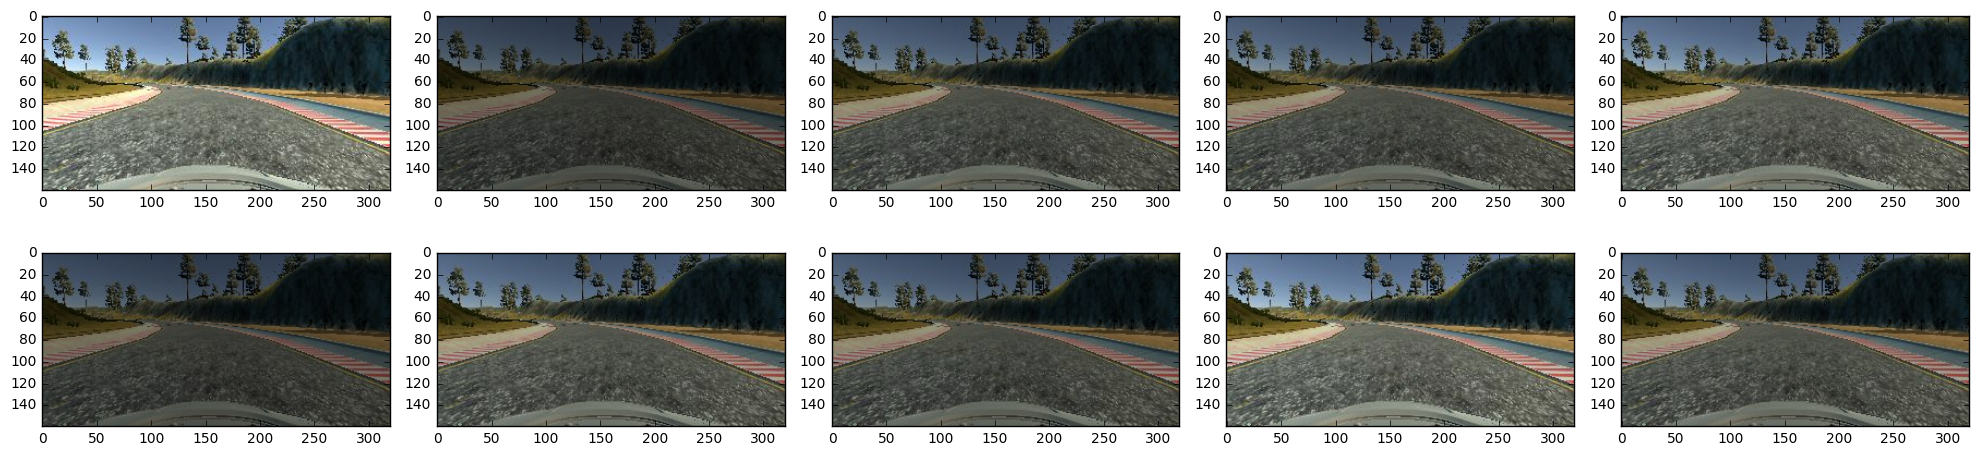

In [111]:
# Check change_brightness function

center_image = plt.imread(X_train["center_image"][0])
angle = X_train["steering_angle"][0]

print ("angle:", angle)

plt.rcParams["figure.figsize"] = [20, 5]
for i in range(0, 10):
    plt.subplot(2, 5, i+1) 
    plt.tight_layout()
    if i == 0:
        plt.imshow(center_image) 
    else:
        plt.imshow(change_brightness(center_image))

('center_image: ', (160, 320, 3))
('resize_img: ', (84, 320, 3))


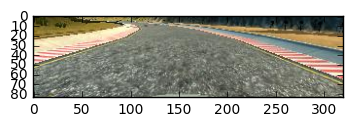

In [112]:
def preprocessImage(image):
    # Proportionally get lower half portion of the image
    nrow, ncol, nchannel = image.shape
    
    start_row = int(nrow * 0.35)
    end_row = int(nrow * 0.875)   
    
    # This removes most of the sky and small amount below including the hood
    new_image = image[start_row:end_row, :]
    
    # This resizes to 66 x 220 for NVIDIA's model
#     new_image = cv2.resize(new_image, (220,66), interpolation=cv2.INTER_AREA)
    
    return new_image

# Check preprocessImage function (includes resizing to 66 x 220)
print ('center_image: ', center_image.shape)
resize_img = preprocessImage(center_image)
print ('resize_img: ', resize_img.shape)

plt.figure(figsize=(4,3))
plt.imshow(resize_img)

In [114]:
def process_image(data_df, TRAIN = False):

    path_filename = data_df["center_image"][0]
    image = cv2.imread(path_filename)
    angle = data_df['steering_angle'][0]
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)    
    image = change_brightness(image)
    
    # Coin flip to see to flip image and create a new sample of -angle
    if (TRAIN):
        if np.random.randint(2) == 1:
            image, angle = flip_image(image, angle)
    
    image = preprocessImage(image)
    image = np.array(image)

    return image, angle



# def preprocess_image_valid(data_row_df):

#     path_filename = data_row_df["center_image"][0]
#     angle = data_row_df['steering_angle'][0]
#     image = cv2.imread(path_filename)
    
#     image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    
#     # Note: drive.py needs to run preprocessImage() when running the simulator
#     image = preprocessImage(image)
#     image = np.array(image)
    
#     return image, angle

('angle:', -0.20087660000000002)
('this_y:', -0.20087660000000002, 'shape:', (84, 320, 3))


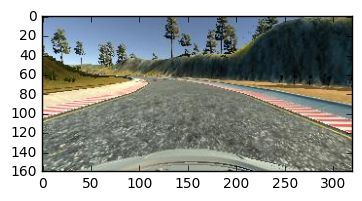

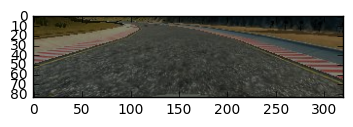

In [121]:
## check if image processing is working properly or not

tst = X_train.iloc[[0]]
tst_path = tst["center_image"][0]
tst_angle = tst["steering_angle"][0]

this_image = cv2.imread(tst_path)
this_image = cv2.cvtColor(this_image,cv2.COLOR_BGR2RGB)

print("angle:", angle)

plt.figure(figsize=(4,3))
plt.imshow(this_image)

this_image, this_y = process_image(tst, False)
print ("this_y:", this_y, "shape:", this_image.shape)

plt.figure(figsize=(4,3))
plt.imshow(this_image)

   index                                       center_image  \
0    275  ../dataFinal/data_udacity/IMG/center_2016_12_0...   

                                          left_image  \
0  ../dataFinal/data_udacity/IMG/left_2016_12_01_...   

                                         right_image  steering_angle  \
0  ../dataFinal/data_udacity/IMG/right_2016_12_01...        0.147877   

   throttle  break     speed  
0  0.985533    0.0  30.18691  


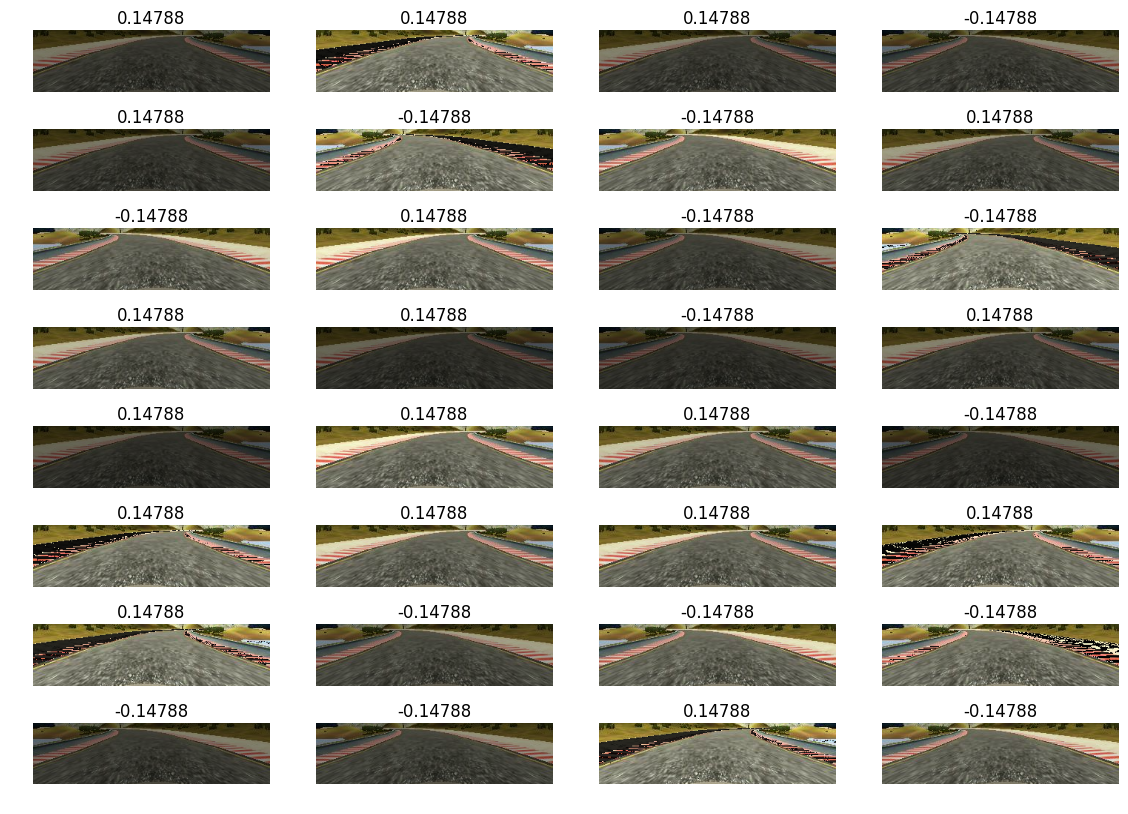

In [122]:
# Check preprocess_image_train function
data_row = df.iloc[[275]].reset_index()
print data_row

plt.figure(figsize=(14, 10))
for i in range(32):
    image, angle = process_image(data_row, True)

    plt.subplot(8,4,i+1)
    plt.imshow(image);
    plt.axis('off')
    plt.title(str(np.round(angle,5)))

In [190]:
# NVIDIA's input parameters
INPUT_IMG_HEIGHT = 84
INPUT_IMG_WIDTH = 320
IMG_CHANNEL = 3

# This will generate a batch of new images of final input dimensions 
# and the y output (steering_angles)
def generate_batch_train_from_dataframe(data_df, batch_size = 128):
    
    batch_images = np.zeros((batch_size, INPUT_IMG_HEIGHT, INPUT_IMG_WIDTH, 3))
    batch_angles = np.zeros(batch_size)
    
    while True:
        for i in range (batch_size):
            # Randomly get a sample from the input data
            idx = np.random.randint(len(data_df))

            # reset_index sets this df starting row to 0
            data_row = data_df.iloc[[idx]].reset_index()
            img1, angle1 = process_image(data_row, True)

            batch_images[i] = img1
            batch_angles[i] = angle1

        yield batch_images, batch_angles
    
def generate_valid_from_dataframe(data_df):
    while True:
        for idx in range(len(data_df)):
            data_row = data_df.iloc[[idx]].reset_index()
            img, angle = process_image(data_row,False)
            # Since not stacking the images, it's shape remains (height, width, channel)
            # but need it to be (1, height, width, channel)
            img = img.reshape(1, img.shape[0], img.shape[1], img.shape[2])
            angle = np.array([[angle]])
            yield img, angle
            
            
def process_image_batch(data_df, TRAIN = False):
    images = []
    angles = []
    for i in range(len(data_df)):
        path_filename = data_df["center_image"][i]
        image = cv2.imread(path_filename)
        angle = data_df['steering_angle'][i]
    
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)    
        image = change_brightness(image)
        # Coin flip to see to flip image and create a new sample of -angle
        if (TRAIN):
            if np.random.randint(2) == 1:
                image, angle = flip_image(image, angle)
        image = preprocessImage(image)
        images.append(image)
        angles.append(angle)
    images = np.array(images)
    angles = np.array(angles)
    return images, angles


def generator(data_df, batch_size=32, TRAIN = False):
    num_samples = len(data_df)
    
    while True: # Loop forever so the generator never terminates
        for offset in range(0, num_samples, batch_size):
    #         batch_samples_images = images[offset:offset+batch_size,:,:,:]
    #         batch_samples_angles = angles[offset:offset+batch_size]
            # reset_index sets this df starting row to 0
            data_row = data_df[offset:offset+batch_size].reset_index()
            X_train, y_train = process_image_batch(data_row, TRAIN)
#             return X_train, y_train
            yield sklearn.utils.shuffle(X_train, y_train)


In [188]:
temp, tempy = generator(X_train, 10, True)
print len(tempy)
print tempy

flip created
flip created
flip created
flip created
flip created
10
10
10
[ 0.2008766  -0.28323151  0.17761091  0.16632173 -0.28692603  0.21765061
 -0.40518469 -0.15212148  0.06925154 -0.27696538]


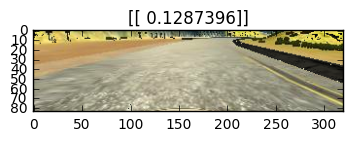

In [140]:
# Initialize generator
valid_data_generator = generate_valid_from_dataframe(X_valid)

# Testing the generator
for i in range(100):
    next(valid_data_generator)

plt.figure(figsize=(4, 3))    
img, angle = next(valid_data_generator)
plt.imshow(img[0])
plt.title(str(angle))

In [141]:
print("img_height:", INPUT_IMG_HEIGHT)
print("img_width:", INPUT_IMG_WIDTH)
print("img_channel:", IMG_CHANNEL)
print("len(X_train_data:)", len(X_train))
print("len(X_valid_data:)", len(X_valid))

('img_height:', 84)
('img_width:', 320)
('img_channel:', 3)
('len(X_train_data:)', 19997)
('len(X_valid_data:)', 5000)


In [142]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, SpatialDropout2D, ELU
from keras.layers import Convolution2D, MaxPooling2D, Cropping2D
from keras.layers import Lambda, Input
from keras.regularizers import l2
from keras.optimizers import SGD, Adam, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import glob
import os
from pathlib import Path
import json

# This is the image size after processing


nb_train_samples = len(X_train)
nb_validation_samples = len(X_valid)
nb_epoch = 6


In [143]:
def get_model_nvidia():
    model = Sequential()
    
    input_shape = (INPUT_IMG_HEIGHT, INPUT_IMG_WIDTH, 3)
    model.add(Lambda(lambda x: x/127.5 - 1.,input_shape = input_shape))
    model.add(Convolution2D(24, 5, 5, subsample=(2, 2), border_mode="valid", init='he_normal', name='conv1'))
    model.add(ELU())
    model.add(Convolution2D(36, 5, 5, subsample=(2, 2), border_mode="valid", init='he_normal', name='conv2'))
    model.add(ELU())
    model.add(Convolution2D(48, 5, 5, subsample=(2, 2), border_mode="valid", init='he_normal', name='conv3'))
    model.add(ELU())
    model.add(Convolution2D(64, 3, 3, subsample=(1, 1), border_mode="valid", init='he_normal', name='conv4'))
    model.add(ELU())
    model.add(Convolution2D(64, 3, 3, subsample=(1, 1), border_mode="valid", init='he_normal', name='conv5'))
    model.add(Flatten(name='flatten1'))
    model.add(ELU())
    model.add(Dense(1164, init='he_normal', name='dense1'))
    model.add(ELU())
    model.add(Dense(100, init='he_normal', name='dense2'))
    model.add(ELU())
    model.add(Dense(50, init='he_normal', name='dense3'))
    model.add(ELU())
    model.add(Dense(10, init='he_normal', name='dense4'))
    model.add(ELU())
    model.add(Dense(1, init='he_normal', name='dense5'))

    adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.01)
    model.compile(optimizer=adam, loss='mse')
    
    return model

In [158]:
def vgg16_net():
    
    model = Sequential()
    ## 2. Data Preprocessing functions
    # Crop 70 pixels from the top of the image and 25 from the bottom
#     model.add(Cropping2D(cropping=((70, 25), (0, 0)), input_shape=(160, 320, 3)))
#     model.add(Lambda(lambda x: x/255. - 0.5) )
    input_shape = (INPUT_IMG_HEIGHT, INPUT_IMG_WIDTH, 3)
    model.add(Lambda(lambda x: x/127.5 - 1.,input_shape = input_shape))
    
    # Block 1
    model.add(Convolution2D(64, 3, 3, border_mode='same'))
    model.add(ELU())
    model.add(Convolution2D(64, 3, 3, border_mode='same') )
    model.add(ELU())
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 2
    model.add(Convolution2D(128, 3, 3, border_mode='same'))
    model.add(ELU())
    model.add(Convolution2D(128, 3, 3, border_mode='same'))
    model.add(ELU())
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 3
    model.add(Convolution2D(256, 3, 3, border_mode='same'))
    model.add(ELU())
    model.add(Convolution2D(256, 3, 3, border_mode='same'))
    model.add(ELU())
    model.add(Convolution2D(256, 3, 3, border_mode='same'))
    model.add(ELU())
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 4
    model.add(Convolution2D(512, 3, 3, border_mode='same'))
    model.add(ELU())
    model.add(Convolution2D(512, 3, 3, border_mode='same'))
    model.add(ELU())
    model.add(Convolution2D(512, 3, 3, border_mode='same'))
    model.add(ELU())
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 5
    model.add(Convolution2D(512, 3, 3, border_mode='same'))
    model.add(ELU())
    model.add(Convolution2D(512, 3, 3, border_mode='same'))
    model.add(ELU())
    model.add(Convolution2D(512, 3, 3, border_mode='same'))
    model.add(ELU())
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

#     if include_top:
        # Classification block
    model.add(Flatten(name='flatten'))
    model.add(Dense(4096) )
    model.add(Dropout(.2))
    model.add(ELU())
    model.add(Dense(2048) )
    model.add(Dropout(.5))
    model.add(ELU())
    model.add(Dense(1000) )
    model.add(Dropout(.5))
    model.add(ELU())
#     model.add(Dense(512) )
#     model.add(ELU())
#     model.add(Dense(256))
#     model.add(ELU())
#     model.add(Dense(128))
#     model.add(ELU())
    model.add(Dense(1))
#         x = Dense(1000, activation='softmax', name='predictions')(x)
    return model   

In [201]:
def model_cnn():

    model = Sequential()
    ## 2. Data Preprocessing functions
    # Crop 70 pixels from the top of the image and 25 from the bottom
#     model.add(Cropping2D(cropping=((70, 25), (0, 0)), input_shape=(160, 320, 3)))
#     model.add(Lambda(lambda x: x/255. - 0.5) )
    input_shape = (INPUT_IMG_HEIGHT, INPUT_IMG_WIDTH, 3)
    model.add(Lambda(lambda x: x/127.5 - 1.,input_shape = input_shape))


    # CNN Model
    model.add(Convolution2D(32, 3, 3, init='he_normal', W_regularizer=l2(l2_reg)) )
    model.add(ELU())
    model.add(Convolution2D(32, 3, 3, init='he_normal', W_regularizer=l2(l2_reg)) )
    model.add(ELU())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, border_mode='valid') )
    # 30x30x32
    model.add(Convolution2D(64, 3, 3, init='he_normal', W_regularizer=l2(l2_reg)) )
    model.add(ELU())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, border_mode='valid') )
    # 14x14x64
    model.add(Convolution2D(128, 3, 3, init='he_normal', W_regularizer=l2(l2_reg)) )
    model.add(ELU())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, border_mode='valid') )
    # 6x6x128
    model.add(Convolution2D(256, 3, 3, init='he_normal', W_regularizer=l2(l2_reg)) )
    model.add(ELU())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, border_mode='valid') )
    # 2x2x256
    model.add(Flatten())
    model.add(Dense(512, init='he_normal' ) )
    model.add(ELU())
    model.add(Dropout(keep_prob) )
    model.add(Dense(256, init='he_normal') )
    model.add(ELU())
    model.add(Dropout(keep_prob) )
    model.add(Dense(128, init='he_normal') )
    model.add(ELU())
    model.add(Dropout(keep_prob) )
    model.add(Dense(64, init='he_normal', W_regularizer=l2(l2_reg)) )
    model.add(ELU())
    model.add(Dense(16, init='he_normal', W_regularizer=l2(l2_reg)) )
    model.add(ELU())
    model.add(Dense(1))

    return model

In [207]:
# from pathlib import Path


l2_reg = 0.001
learning_rate = 0.0007
keep_prob = 0.5
batch_size = 64
# Training settings
min_delta=1e-4
patience=4

beta2 = 0.999
beta1 = 0.9
epsilon = 1e-08
decay = 0.01
lr = 0.001


model = model_cnn()#vgg16_net()#model_cnn() #nvidia_subset() #get_model_nvidia()
adam = Adam(lr=lr, beta_1=beta1, beta_2=beta2, epsilon=epsilon, decay= decay)
print("Model summary:\n", model.summary())
model.compile(optimizer=adam, loss="mse", metrics=['mean_absolute_error'])


# Clear TensorBoard Logs
for file in os.listdir('./logs/'):
    os.remove('./logs/' + file)

filelist = glob.glob("Models/*.*")
for f in filelist:
    os.remove(f)
#     os.remove('model.json')
#     os.remove('model.h5')


val_size = len(X_valid)


# valid_data_generator = generate_valid_from_dataframe(X_valid)
# train_data_generator = generate_batch_train_from_dataframe(X_train, batch_size)

# compile and train the model using the generator function
train_generator = generator(X_train, batch_size, True)
validation_generator = generator(X_train, batch_size, False)

# Model training
filepath = 'Models/model.h5'


callbacks = [
    EarlyStopping(monitor='val_loss', min_delta=min_delta, patience=patience, mode='min'),
    ModelCheckpoint(filepath=filepath, monitor='val_loss', save_best_only=True, save_weights_only=False, mode='min'),
    TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True)
  ]

# model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
# model.fit(X_train, y_train, validation_split=0.2,shuffle=True,nb_epoch=7, verbose=1)
model.fit_generator(train_generator, samples_per_epoch=len(X_train), validation_data=validation_generator,
                   nb_val_samples=len(X_valid),nb_epoch=100, verbose=1, callbacks=callbacks)

def save_model(fileModelJSON, fileWeights):
    prefix = "./Models/"
    
    filenameJSON = prefix + fileModelJSON
    if Path(filenameJSON).is_file():
        os.remove(filenameJSON)    
    with open (filenameJSON, 'w') as outfile:
        json.dump(model.to_json(), outfile)
        
    filenameWeights = prefix + fileWeights
    if Path(filenameWeights).is_file():
        os.remove(filenameWeights)
    model.save_weights(filenameWeights, True)

fileModelJSON = 'model_cnn' + '.json'
fileWeights = 'model_cnn' + '.h5'
save_model(fileModelJSON, fileWeights)
print('model saved')

# # model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
# # model.fit(X_train, y_train, validation_split=0.2,shuffle=True,nb_epoch=7, verbose=1)
# model.fit_generator(train_generator, samples_per_epoch=len(train_samples), validation_data=validation_generator,
#                    nb_val_samples=len(validation_samples),nb_epoch=35, verbose=1, callbacks=callbacks)


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_21 (Lambda)               (None, 84, 320, 3)    0           lambda_input_21[0][0]            
____________________________________________________________________________________________________
convolution2d_70 (Convolution2D) (None, 82, 318, 32)   896         lambda_21[0][0]                  
____________________________________________________________________________________________________
elu_196 (ELU)                    (None, 82, 318, 32)   0           convolution2d_70[0][0]           
____________________________________________________________________________________________________
convolution2d_71 (Convolution2D) (None, 80, 316, 32)   9248        elu_196[0][0]                    
___________________________________________________________________________________________